# MATH&ML-13. Временные ряды. Часть II

Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima
from arch import arch_model
from sklearn.linear_model import LinearRegression
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [7]:
gdp = pd.read_csv('ghana_gdp.zip', index_col='year', parse_dates=['year'])
gdp.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


---

## 1. Статистические модели прогнозирования

#### Скользящее среднее

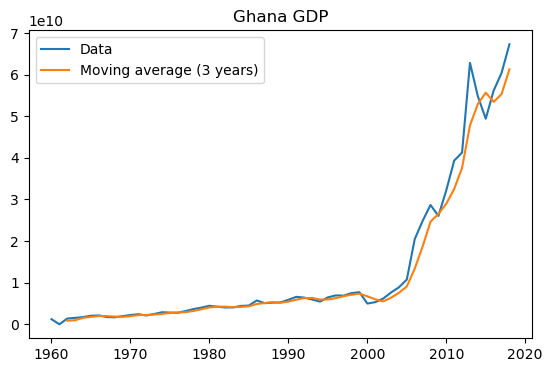

In [9]:
# Train / test data
train, test = gdp[:-3].copy(), gdp[-3:].copy()

# Moving average
ma = train.rolling(window=3).mean()

plt.figure(figsize=(6.5, 4))
plt.plot(train, label='Data')
plt.plot(ma, label='Moving average (3 years)')
plt.title('Ghana GDP')
plt.legend()

* С 1960 по 2000 год ВВП Ганы оставался относительно стабильным с незначительным ростом. Начиная с 2000-х годов, наблюдается значительный и устойчивый рост ВВП, что указывает на ускоренное экономическое развитие страны в этот период.

* Синяя линия данных показывает колебания ВВП, особенно после 2000 года. Это указывает на возможные экономические потрясения, колебания цен на сырьевые товары или другие экономические факторы, влияющие на ВВП.

* Оранжевая линия сглаживает колебания и дает более четкое представление о долгосрочном тренде. Она показывает, что несмотря на колебания, общий тренд ВВП Ганы с начала 2000-х годов является восходящим.

* В период после 2000 года могут быть связаны с крупными экономическими реформами, инвестициями, изменением мировых цен на товары (например, на нефть или золото), которые могли оказать значительное влияние на экономику Ганы.

#### Тест на стационарность

In [15]:
# Dickey-Fuller test
aftest = adfuller(train)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

Statistics: 0.6529066974885372
p_value: 0.9888496277665573
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}



In [36]:
# 1st order differentiation
diff1 = train.diff()[1:]
aftest = adfuller(diff1)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

Statistics: -1.8255652246436003
p_value: 0.36784515276563406
Critical values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}



In [12]:
# 2nd order differentiation
diff2 = diff1.diff()[1:]
aftest = adfuller(diff2)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

Statistics: -2.6408690561284844
p_value: 0.08484116917837775
Critical values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}



In [17]:
# 3rd order differentiation
diff3 = diff2.diff()[1:]
aftest = adfuller(diff3)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}')

Statistics: -4.779623784828534
p_value: 5.948327640224872e-05
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


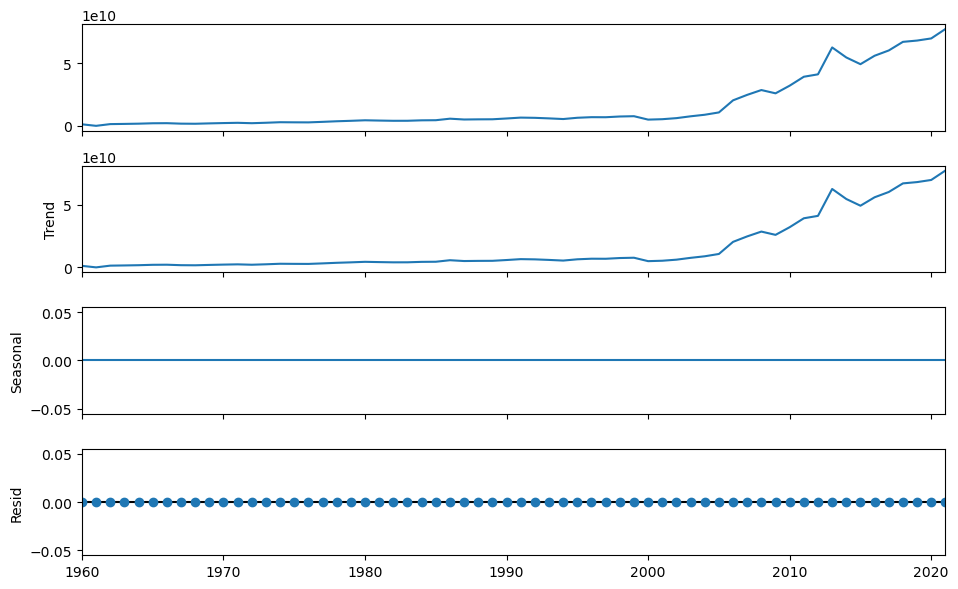

In [14]:
# seasonal decompose
decomposition = seasonal_decompose(gdp) 
fig = decomposition.plot()
fig.set_size_inches((9.7, 6))
fig.tight_layout()

* Временной ряд нестационарен. Интегрированный ряд третьего порядка. 
* Применяем прогноз ARIMA: авторегрессия со скользящим средним для нестационарного ряда, сезонность отсутствует.

#### Прогноз ARIMA

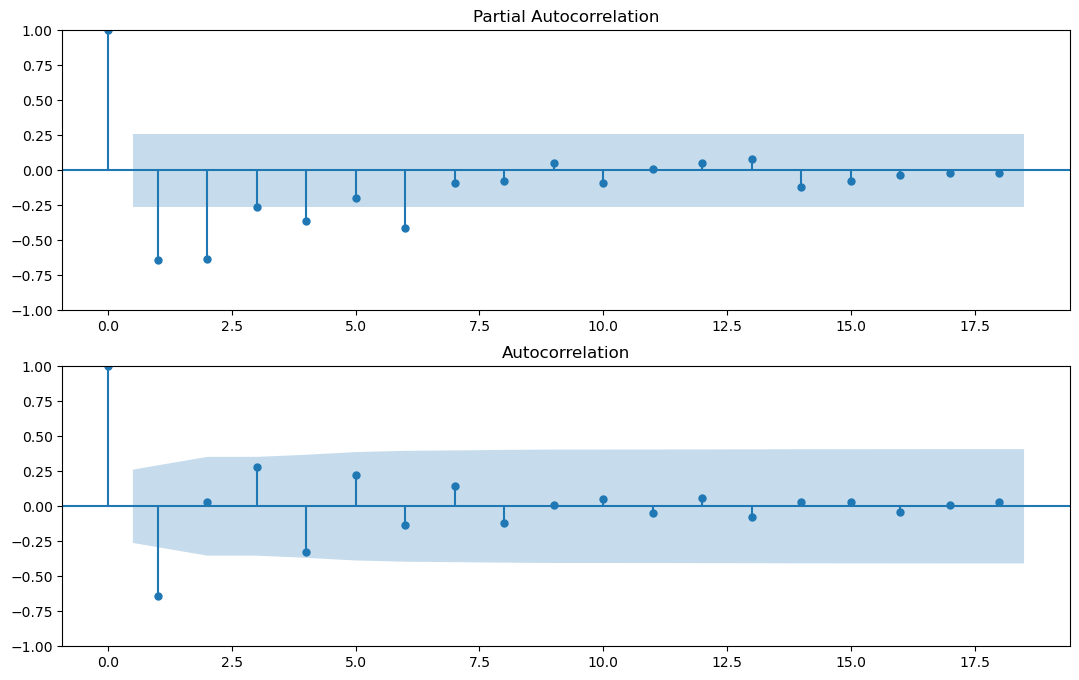

In [18]:
# select parameters
fig, ax = plt.subplots(2, 1, figsize=(13,8))
tsaplots.plot_pacf(diff3, method='ywm', ax=ax[0])
tsaplots.plot_acf(diff3, ax=ax[1])
plt.show()

* Параметры ARIMA: p=2 (по частичной автокорреляции), d=3 (интегрированный ряд третьего порядка), q=1 (по автокорреляции)

In [19]:
# model
model = ARIMA(train, order=(2, 3, 1))
model_fit = model.fit()
model_fit.summary()

/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 16 Aug 2024   AIC                           2659.231
Time:                        09:17:02   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.74e+57. Standard errors may be unstable.
"""

#### Побор лучших параметров с помощью pmdarima. 

* Параметр p: в диапазоне 1-6
* Параметр q: в диапазоне 1-2
* Оставляем интегрированный ряд третьего порядка: d=3, stationarity=False
* Задаем отсутствие сезонности: seasonal=False

In [20]:
opt_params = pmdarima.auto_arima(
    train,
    start_p=1, start_q=1,
    max_p=6, max_q=2,
    d=3, stationarity=False, seasonal=False,
    trace=True
)    
opt_params.summary()

Performing stepwise search to minimize aic
 ARIMA(1,3,1)(0,0,0)[0]             : AIC=2670.910, Time=0.02 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.01 sec
 ARIMA(2,3,1)(0,0,0)[0]             : AIC=2659.231, Time=0.01 sec
 ARIMA(2,3,0)(0,0,0)[0]             : AIC=2679.050, Time=0.01 sec
 ARIMA(3,3,1)(0,0,0)[0]             : AIC=2660.791, Time=0.01 sec
 ARIMA(2,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,3,2)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.01 sec
 ARIMA(3,3,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(2,3,1)(0,0,0)[0] intercept   : AIC=2666.241, Time=0.01 sec

Best model:  ARIMA(2,3,1)(0,0,0)[0]          
Total fit time: 0.200 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(2, 3, 1)   Log Likelihood               -1325.615
Date:                Fri, 16 Aug 2024   AIC                           2659.231
Time:                        09:18:06   BIC                           2667.332
Sample:                    01-01-1960   HQIC                          2662.372
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.129     -5.765      0.000      -0.995      -0.490
ar.L2         -0.4577      0.223     -2.055      0.040      -0.894      -0.021
ma.L1         -0.9730      0.110     -8.808      0.000      -1.189      -0.756
sigma2      3.138e+19   5.16e-22   6.08e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               161.83
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):             392.62   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.74e+57. Standard errors may be unstable.
"""

* Лучшие параметры остались прежними

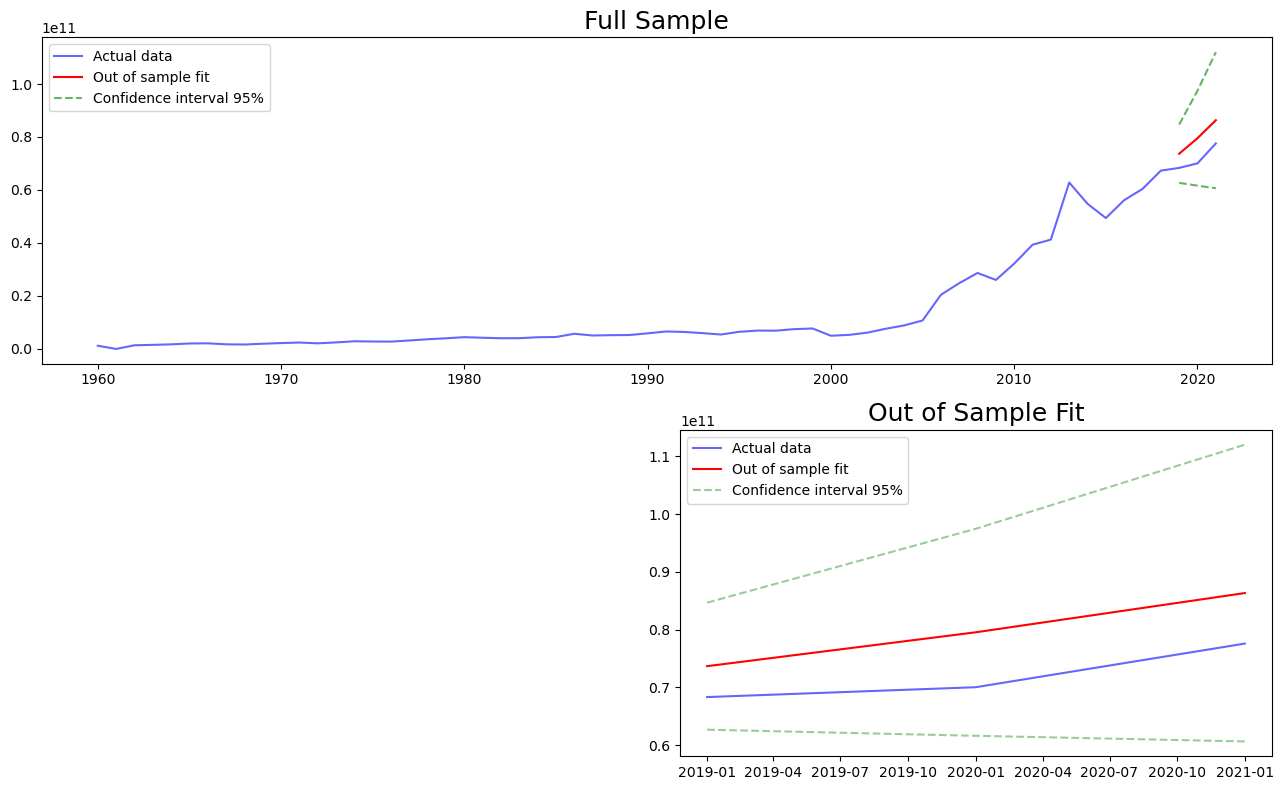

In [21]:
# prediction
gdp['model_preds'] = model_fit.predict(start=test.index[0], end=test.index[-1])

# confidence interval
forecast = model_fit.get_forecast(test.shape[0])
forecast_df = forecast.conf_int(alpha=0.05)  # confidence level of 95%
gdp.at[test.index, 'model_preds_lower'] = forecast_df['lower GDP (current US$)']
gdp.at[test.index, 'model_preds_upper'] = forecast_df['upper GDP (current US$)']

# visualization
plt.figure(figsize=(13, 8))

plt.subplot(2, 1, 1)
plt.plot(gdp['GDP (current US$)'], color='blue', 
         label='Actual data', alpha=0.6)
plt.plot(gdp.loc[test.index]['model_preds'], color='red', 
         linestyle='-', label='Out of sample fit')
plt.plot(gdp.loc[test.index]['model_preds_lower'], color='green', 
         linestyle='--', label='Confidence interval 95%', alpha=0.6)
plt.plot(gdp.loc[test.index]['model_preds_upper'], color='green', 
         linestyle='--', alpha=0.6)
plt.title('Full Sample', size=18)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(gdp.loc[test.index]['GDP (current US$)'], color='blue', 
         label='Actual data', alpha=0.6)
plt.plot(gdp.loc[test.index]['model_preds'], color='red', linestyle='-', 
         label='Out of sample fit')
plt.plot(gdp.loc[test.index]['model_preds_lower'], color='green', 
         linestyle='--', label='Confidence interval 95%', alpha=0.4)
plt.plot(gdp.loc[test.index]['model_preds_upper'], color='green', 
         linestyle='--', alpha=0.4)
plt.title('Out of Sample Fit', size=18)
plt.legend()

plt.tight_layout()
plt.show()

#### Вывод

Построен прогноз по модели ARIMA. Сезонность временного ряда отсутствует. Прогноз завышен. Фактические значения не выходят за пределы 95%-го доверительного интервала.

## 2. Интерполяция и сэмлирование

#### Проверка на пропущенные значения

In [40]:
gdp = pd.read_csv('ghana_gdp.zip', index_col='year', parse_dates=['year'])
gdp = gdp.asfreq(freq='YS')
gdp.isna().sum()

GDP (current US$)    0
dtype: int64

#### Проверка на нулевые значения

In [41]:
gdp[gdp['GDP (current US$)'] == 0]

,GDP (current US$)
year,
1961-01-01,0.0


#### Замена на NaN

In [42]:
gdp['GDP (current US$)'] = gdp['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

#### Линейная интерполяция нулевых значений

In [43]:
gdp['GDP (current US$)'] = gdp['GDP (current US$)'].interpolate(method='linear')

#### Тест на стационарность

In [44]:
# train / test data
train, test  = gdp[:-3].copy(), gdp[-3:].copy()

In [45]:
# Dickey-Fuller test
aftest = adfuller(train)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

Statistics: 0.803007332698012
p_value: 0.9916845572455877
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}



In [46]:
# 1st order differentiation
diff1 = train.diff()[1:]
aftest = adfuller(diff1)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

Statistics: -1.8255652246436003
p_value: 0.36784515276563406
Critical values: {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}



In [47]:
# 2nd order differentiation
diff2 = diff1.diff()[1:]
aftest = adfuller(diff2)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}\n')

Statistics: -2.634634746007846
p_value: 0.08604813722197618
Critical values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}



In [48]:
# 3rd order differentiation
diff3 = diff2.diff()[1:]
aftest = adfuller(diff3)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}')

Statistics: -4.825603687304032
p_value: 4.857318076799709e-05
Critical values: {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}


* Временной ряд нестационарен. Интегрирование третьего порядка.

#### Прогноз ARIMA

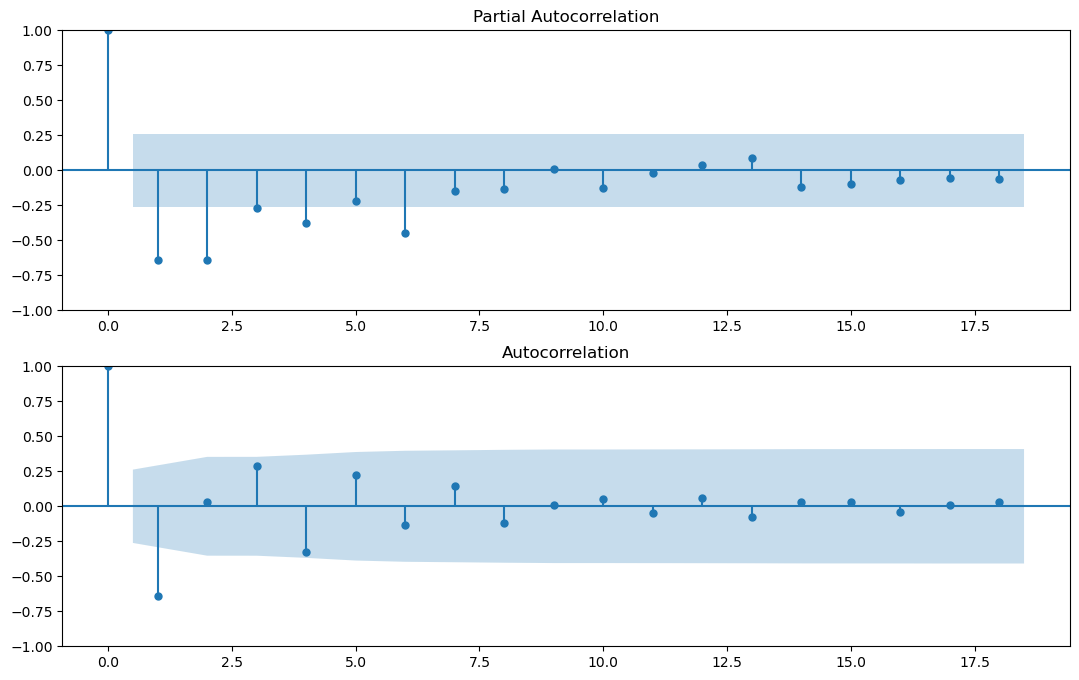

In [49]:
# select parameters
fig, ax = plt.subplots(2, 1, figsize=(13,8))
tsaplots.plot_pacf(diff3, method='ywm', ax=ax[0])
tsaplots.plot_acf(diff3, ax=ax[1])
plt.show()

* Параметры ARIMA: p = 2, d = 3, q = 1

In [50]:
# model
model = ARIMA(train, order=(2, 3, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 3, 1)   Log Likelihood               -1325.613
Date:                Fri, 16 Aug 2024   AIC                           2659.226
Time:                        09:31:16   BIC                           2667.328
Sample:                    01-01-1960   HQIC                          2662.367
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7420      0.129     -5.756      0.000      -0.995      -0.489
ar.L2         -0.4585      0.223     -2.056      0.040      -0.895      -0.022
ma.L1         -0.9729      0.110     -8.806      0.000      -1.189      -0.756
sigma2      3.139e+19   4.77e-22   6.58e+40      0.000    3.14e+19    3.14e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               163.47
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):             440.85   Skew:                            -0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.44e+56. Standard errors may be unstable.
"""

#### Вывод

* Нулевое значение временного ряда (1961-01-01) заменено на линейноинтерполированное значение. Критерий Акаике (AIC) уменьшился на небольшую величину (2659.231 -> 2659.226), т.е. качество модели немного улучшилось.

## 3. Гетероскедастичность

#### Волатильность

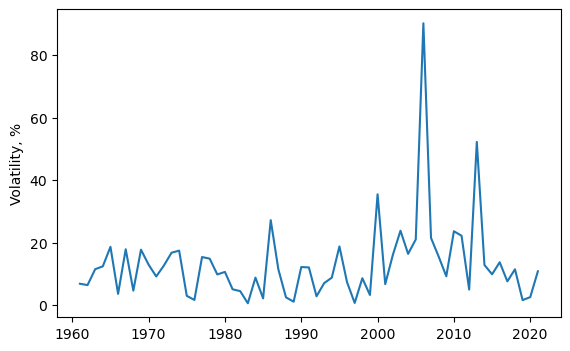

In [51]:
volat = (gdp.pct_change().abs() * 100)[1:]

plt.figure(figsize=(6.5, 4))
plt.plot(volat)
plt.ylabel('Volatility, %')
plt.show()

#### Модель GARCH

In [55]:
# train/test
train, test = volat[:-3], volat[-3:]

# Dickey-Fuller test
aftest = adfuller(train)
print(f'Statistics: {aftest[0]}')
print(f'p_value: {aftest[1]}')
print(f'Critical values: {aftest[4]}')

Statistics: -6.725311059553779
p_value: 3.4014596148856493e-09
Critical values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}


* Ряд стационарен

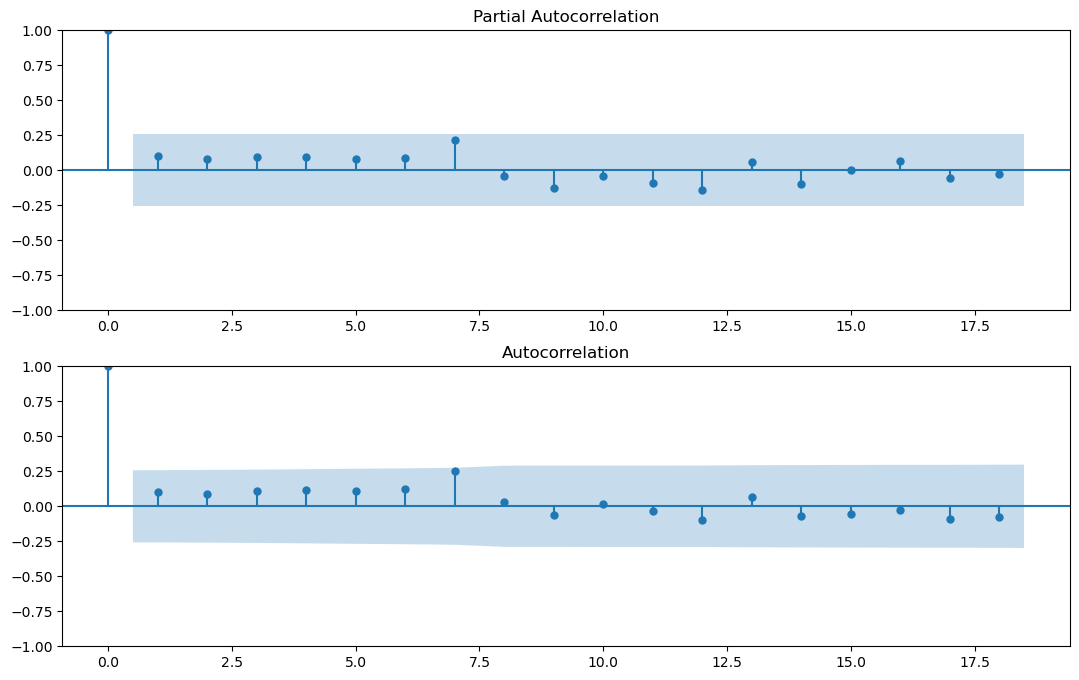

In [56]:
# select parameters
fig, ax = plt.subplots(2, 1, figsize=(13,8))
tsaplots.plot_pacf(train, method='ywm', ax=ax[0])
tsaplots.plot_acf(train, ax=ax[1])
plt.show()

* Автокорреляция отсутствует, выбираем минимальные параметры GARCH: p = 1, q = 1

In [59]:
model = arch_model(volat, vol='GARCH', p=1, q=1)
model_results = model.fit(last_obs=train.index[-1], update_freq=5)

garch_pred = model_results.forecast(reindex=False).variance.loc[test.index]

Iteration:      5,   Func. Count:     27,   Neg. LLF: 247.95412372386892
Iteration:     10,   Func. Count:     57,   Neg. LLF: 237.65935576622067
Iteration:     15,   Func. Count:     85,   Neg. LLF: 223.28139246857188
Iteration:     20,   Func. Count:    109,   Neg. LLF: 222.86320883014378
Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.86320787129145
            Iterations: 20
            Function evaluations: 109
            Gradient evaluations: 20


#### Линейная регрессия

In [60]:
X_train = np.array(range(train.shape[0])).reshape(-1, 1)
y_train = train.values[:, 0]
X_test = np.array(range(
    train.shape[0], train.shape[0] + test.shape[0])).reshape(-1, 1)
y_test = test.values[:, 0]

regr = LinearRegression()
regr.fit(X_train, y_train)
regr_pred = regr.predict(X_test)
regr_pred = pd.Series(regr_pred, index=test.index)

#### Сравнение результатов

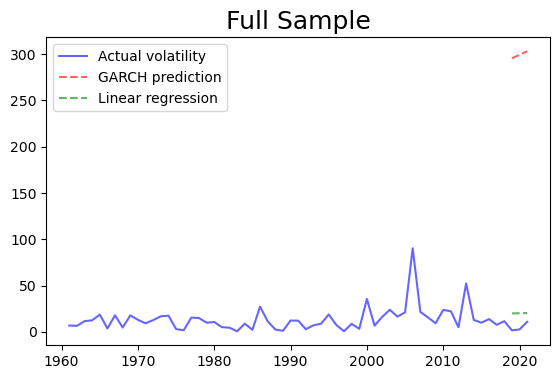

In [61]:
plt.figure(figsize=(6.5, 4))
plt.plot(volat, color='blue', label='Actual volatility', alpha=0.6)
plt.plot(garch_pred, color='red', linestyle='--', 
         label='GARCH prediction', alpha=0.6)
plt.plot(regr_pred, color='green', linestyle='--', 
         label='Linear regression', alpha=0.6)
plt.title('Full Sample', size=18)
plt.legend()
plt.show()

#### Вывод

* Модель GARCH демонстрирует значительное расхождение с фактическими значениями волатильности. 
* Анализ автокорреляционных функций показал отсутствие автокорреляции в данном ряде, что свидетельствует о слабом влиянии предыдущих значений на последующие. Это указывает на то, что модель GARCH в данной ситуации не подходит. 
* Возможно, что при наличии более длинного ряда такая зависимость могла бы проявиться. Прогноз, полученный с помощью простой линейной регрессии, оказался более правдоподобным.